In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque


/Users/joshp/.pyenv/versions/3.11.6/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Boards are represented as 2d grids of numbers with 11 being unknown, 12 being a mine and 0-8 being the number of mines a square borders (the numbers in the game)



In [2]:


def countMines(board, row, col, rows, cols):
    count = 0
    for i in range(max(0, row-1), min(rows, row+2)):
        for j in range(max(0, col-1), min(cols, col+2)):
            if i != row or j != col:
                if board[i][j] == 12:
                    count += 1
    return count

def genFinalBoard(rows, cols, numMines):
    board = torch.zeros(rows, cols)
    while numMines > 0:
        row = random.randint(0, rows-1)
        col = random.randint(0, cols-1)
        if board[row][col] != 12:
            board[row][col] = 12
            numMines -= 1

    for i in range(rows):
        for j in range(cols):
            if board[i][j] != 12:
                board[i][j] = countMines(board, i, j, rows, cols)
    #print(board)
    return board




def genInitialBoard(finalboard):
    shape = finalboard.shape
    rows = shape[0]
    cols = shape[1]
    board = torch.full((rows, cols), 11)
    #print(board)
    return board


def getY(rows, cols, fb):
    yboard = torch.zeros(rows, cols)
    for i in range(rows):
        for j in range(cols):
            if fb[i][j] == 12:
                yboard[i][j] = 1
    return yboard

def haswon(board, numMines):
    num_11s = torch.sum(board == 11).item()

    if num_11s == numMines and torch.sum(board == 12) == 0:
        return True
    else:
        return False
def haslost(board):
  if torch.sum(board == 12) == 0:
    return False
  return True


def queryCreate(finalboard, currentboard, row, col):
    finalboard_list = finalboard.tolist()
    if(finalboard[row][col] == 10).all():
      currentboard[row][col] = 10
      return currentboard
    currentboard[row][col] = finalboard[row][col]
    if finalboard[row][col] == 0:
        offsets = [(i, j) for i in range(-1, 2) for j in range(-1, 2) if i != 0 or j != 0]
        for offset_row, offset_col in offsets:
            new_row, new_col = row + offset_row, col + offset_col

            if 0 <= new_row < len(finalboard) and 0 <= new_col < len(finalboard[0]) and currentboard[new_row][new_col] == 11:
                queryCreate(finalboard, currentboard, new_row, new_col)

    return currentboard


def queryGuess(finalboard, currentboard, row, col):
    finalboard_list = finalboard.tolist()
    if(finalboard[row][col] == 12).all():
      currentboard[row][col] = 12
      return currentboard
    currentboard[row][col] = finalboard[row][col]
    num = finalboard[row[0]][col[0]]
    row = row[0]
    col = col[0]
    if num == 0:
        offsets = [(i, j) for i in range(-1, 2) for j in range(-1, 2) if i != 0 or j != 0]
        for offset_row, offset_col in offsets:
            new_row, new_col = row + offset_row, col + offset_col

            if 0 <= new_row < len(finalboard) and 0 <= new_col < len(finalboard[0]) and currentboard[new_row][new_col] == 11:
                #print("HERE")
                queryCreate(finalboard, currentboard, new_row, new_col)

    return currentboard

#fb = genFinalBoard(9, 9, 10)
#ib = genInitialBoard(fb.clone())

#print(query(fb, ib, 0, 0))


In [3]:
def handleGuess(gb, fb, cb):
    sorted_rows_indices = torch.argsort(gb, dim=0)
    sorted_cols_indices = torch.argsort(gb, dim=1)
    sorted_rows_indices = sorted_rows_indices.flatten()
    sorted_cols_indices = sorted_cols_indices.flatten()
    #sorted_rows = sorted_rows_indices[:, 0]
    #sorted_cols = sorted_cols_indices[0, :]
    #print(sorted_rows_indices)
    #print(sorted_cols_indices)
    min_values, col_indices = torch.min(gb, dim=1)

    smallest_value, row_index = torch.min(min_values, dim=0)

    col_index = col_indices[row_index]


    #print(gb)
    #mv = torch.min(gb)
    #print(gb[sorted_rows_indices[0]][sorted_cols_indices[0]])
    #print(gb[row_index][col_index])
    #print(mv)
    i = 0
    for i in range (81):
        min_values, col_indices = torch.min(gb, dim=1)

        smallest_value, row_index = torch.min(min_values, dim=0)

        col_index = col_indices[row_index]
        ent = cb[row_index][col_index].item() #making sure we're not picking an entry we picked

        if ent == 11:
          #print(fb)
          cb = queryCreate(fb, cb, row_index, col_index)
          #print(sorted_rows_indices[i])
          return cb
        else:
          gb[row_index][col_index] = 1000

    # Print sorted rows and columns
    #print("Sorted Rows:", sorted_rows_indices.tolist())
    #print("Sorted Columns:", sorted_cols_indices.tolist())

    return cb

#this handleGuess function is to generate Data so if it selects a 12 it will just move on
def handleGuessData(gb, fb, cb):
    #this shit is wrong
    sorted_rows_indices = torch.argsort(gb, dim=0)
    sorted_cols_indices = torch.argsort(gb, dim=1)
    sorted_rows_indices = sorted_rows_indices.flatten()
    sorted_cols_indices = sorted_cols_indices.flatten()
    #sorted_rows = sorted_rows_indices[:, 0]
    #sorted_cols = sorted_cols_indices[0, :]
    #print(sorted_rows_indices)
    #print(sorted_cols_indices)
    min_values, col_indices = torch.min(gb, dim=1)

    smallest_value, row_index = torch.min(min_values, dim=0)

    col_index = col_indices[row_index]


    #print(gb)
    #mv = torch.min(gb)
    #print(gb[sorted_rows_indices[0]][sorted_cols_indices[0]])
    #print(gb[row_index][col_index])
    #print(mv)
    i = 0
    for i in range (81):
        min_values, col_indices = torch.min(gb, dim=1)

        smallest_value, row_index = torch.min(min_values, dim=0)

        col_index = col_indices[row_index]
        ent = cb[row_index][col_index].item() #making sure we're not picking an entry we picked

        if ent == 11 and fb[row_index][col_index].item() != 12:
          #print(fb[row_index][col_index].item())
          cb = queryCreate(fb, cb, row_index, col_index)
          #print(sorted_rows_indices[i])
          return cb
        else:
          gb[row_index][col_index] = 1000

    # Print sorted rows and columns
    #print("Sorted Rows:", sorted_rows_indices.tolist())
    #print("Sorted Columns:", sorted_cols_indices.tolist())

    return cb



In [4]:
batch_size = 64

def get_batch(x, y, batch_size):
    n = x.shape[0]

    batch_indices = random.sample( [ i for i in range(n) ], k = batch_size )

    x_batch = x[ batch_indices ]
    y_batch = y[ batch_indices ]

    return x_batch, y_batch

In [5]:

def getMines(fb):
    result = torch.zeros_like(fb)
    for i in range(fb.shape[0]):
        for j in range(fb.shape[1]):
            if fb[i][j] == 12:
                result[i][j] = 1.0
            else:
                result[i][j] = 0.0

    return result




def get_safe_move(currentboard, finalboard, rows, cols):
    

    unopened_cells = [(row, col) for row in range(rows) for col in range(cols) if currentboard[row][col].item() == 11]
    if unopened_cells:
        for ent in unopened_cells:
            if finalboard[ent[0]][ent[1]] != 12:
                #print(ent)
                return ent
        #print("ASDF")    
        return random.choice(unopened_cells)
    else:
        return None, None

def get_neighbors(row, col, rows, cols, cb):
    """
    Returns a list of (row, col) tuples representing the neighboring cells of (row, col).
    """
    neighbors = []
    for r in range(max(0, row - 1), min(rows, row + 2)):
        for c in range(max(0, col - 1), min(cols, col + 2)):
            if (r, c) != (row, col):
                neighbors.append((r, c))
    return neighbors

def genDataSmallBoards(maxrows, maxcols, MaxMines, leng):
    data_x = []
    data_y = []
    final_boards = []
    
    while leng > len(final_boards):
        rows = 3
        cols = 3

        nm = random.randint(1, 4)    
        fb = genFinalBoard(rows, cols, nm)
        yboard = getMines(fb)
        cb = genInitialBoard(fb.clone())

        numi = 0
        while True:
            numtries = 150

            row, col = get_safe_move(cb, fb,rows, cols)
            if row is None and col is None:
                break
                    
            result = queryCreate(fb, cb.clone(), row, col)
            if not torch.all(cb.eq(result))  and fb[row][col].item() != 12:
                cb = result
                #print(cb)
                
                #print(len(final_boards))
                data_x.append(cb)
                data_y.append(yboard)
                final_boards.append(fb)
            numi += 1

            if haswon(cb, nm):
                #print("WWWWW")
                break
            if numi >= numtries:
                #print("LLL")
                break

    return data_x, data_y, final_boards
#30% of a 30 by 30 board is 270
Dataset_x, Dataset_y, finalBoards = genDataSmallBoards(15, 15,7,40000)



print((Dataset_x[1]))
print(Dataset_x[1] == Dataset_x[0])
print(Dataset_y[0])

zipped = list(zip(Dataset_x, Dataset_y, finalBoards))

random.shuffle(zipped)

Dataset_x, Dataset_y, finalBoards = zip(*zipped)



tensor([[11,  3, 11],
        [11, 11, 11],
        [11, 11, 11]])
tensor([[False, False, False],
        [False, False, False],
        [ True, False, False]])
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [1., 0., 0.]])


In [6]:
Data_x = torch.stack(Dataset_x)
Data_y = torch.stack(Dataset_y)
train_x = Data_x[:-250]
print(Data_y.shape)
print(Data_x.shape)
test_x = Data_x[-250:]
train_y = Data_y[:-250]
test_y = Data_y[-250:]
print(train_y.shape)
print(train_x[0])
Data_board = torch.stack(finalBoards)
train_board = Data_board[:-250]
test_board = Data_board[-250:]
print(train_board[0])


torch.Size([40000, 3, 3])
torch.Size([40000, 3, 3])
torch.Size([39750, 3, 3])
tensor([[ 2, 11,  1],
        [11, 11, 11],
        [11, 11, 11]])
tensor([[ 2., 12.,  1.],
        [12.,  4.,  2.],
        [12.,  3., 12.]])


In [7]:
import torch.nn as nn
from torch.nn import TransformerDecoderLayer, TransformerDecoder

class Solver(nn.Module):
    def __init__(self, ):
        super(Solver, self).__init__()
        self.flatten = nn.Flatten()

        # Define the transformer decoder layer
        self.transformer_layer = TransformerDecoderLayer(d_model=27, nhead=1, dim_feedforward=128, dropout=0.1)
        self.transformer = TransformerDecoder(self.transformer_layer, num_layers=2)

        self.layers = nn.ModuleList()
        #self.layers.append(torch.nn.BatchNorm2d(3))
        #self.layers.append(torch.nn.Dropout(0.25))

        #output_shape = 32 * 32 * 3  # Get the flattened output size
        #self.layers.append(nn.Flatten())
        self.layers.append(nn.LayerNorm(27))
        self.layers.append(nn.Linear(in_features=27, out_features=9))
        self.layers.append(nn.Sigmoid())
        #self.layers.append(nn.LayerNorm(128))
        #self.layers.append(nn.Linear(in_features=128, out_features=10))

    def forward(self, input_tensor, verbose=False):
      output = self.flatten(input_tensor)

      if verbose:
          print(output.shape)

      batch_size, _ = output.size()
      dummy_memory = torch.zeros(batch_size, 1, output.size(-1), device=output.device)

      output = self.transformer(output.unsqueeze(1), dummy_memory)  
      if verbose:
          print(output.shape)

      for layer in self.layers:
          output = layer(output)

          if verbose:
              print(output.shape)
      
      output = output.view(output.size(0), -1)
      
      output = output.view(-1, 3, 3)
      return output

In [8]:
def posEncoding(batched_boards):
    batch_size, rows, cols = batched_boards.shape

    value_coordinates = torch.zeros(batch_size, rows, cols, 3)

    for k in range(batch_size):
        for i in range(rows):
            for j in range(cols):
                value_coordinates[k, i, j] = torch.tensor([batched_boards[k, i, j], i, j])
    return value_coordinates
#this is used for training I am adding a random number to the initial rows and columns so that it simulates a larger board
def posEncodingTraining(batched_boards):
    
    batch_size, rows, cols = batched_boards.shape
    initial_row_position = random.randint(0, 50)
    initial_col_position = random.randint(0, 50) 
    value_coordinates = torch.zeros(batch_size, rows, cols, 3)

    for k in range(batch_size):
        for i in range(rows):
            for j in range(cols):
                value_coordinates[k, i, j] = torch.tensor([batched_boards[k, i, j], i+initial_row_position, j+initial_col_position])
    return value_coordinates





In [9]:
model = Solver()

loss_function = torch.nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr = 0.01 )

for epochs in range(10):
    total_loss = 0
    test_loss_total = 0
    for batch in range( train_x.shape[0] // batch_size ):
        x_batch, y_batch = get_batch(train_x, train_y, batch_size)

        x_batch_test, y_batch_test = get_batch(test_x, test_y, batch_size)
        optimizer.zero_grad()
        x_batch = posEncodingTraining(x_batch)
        #print(x_batch.shape)
        x_batch = x_batch.reshape((64, 27))
        if(x_batch.shape[1] == 27):
            output = model(x_batch.float())
        #print(output)

        loss = loss_function( output, y_batch )

        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    output = model( posEncoding(test_x).float() )
    test_loss = loss_function( output, test_y )
    print( "Loss ",loss.item() )
    print( "Test Loss ",test_loss.item() )
output = model( posEncoding(test_x).float() )
print()
test_loss = loss_function( output, test_y )
print("Final Loss")
print(loss.item())
print("Final Test Loss")
print(test_loss.item())

Loss  0.6020474433898926
Test Loss  0.6020581722259521
Loss  0.5997564792633057
Test Loss  0.5997905135154724
Loss  0.61065274477005
Test Loss  0.6017934679985046
Loss  0.6370357275009155
Test Loss  0.6015742421150208
Loss  0.5984618663787842
Test Loss  0.60209059715271
Loss  0.5911056995391846
Test Loss  0.6014893054962158
Loss  0.60655677318573
Test Loss  0.6019708514213562
Loss  0.5983068346977234
Test Loss  0.6019405722618103
Loss  0.6040781140327454
Test Loss  0.6022666096687317
Loss  0.6142752170562744
Test Loss  0.6017801761627197

Final Loss
0.6142752170562744
Final Test Loss
0.6018057465553284


In [12]:

rows = 3
cols = 3


print(Dataset_x[0])
print(Dataset_x[1])
print(len(finalBoards))
winrates = []
boardsizes = []
for k in range (5, 23, 1):
  print(k)
  boardsizes.append(k)
  nummines = k
  losses = 0.0
  wins = 0.0
  for j in range(50):
    fb = genFinalBoard(k, k, int(k*.2))
    yboard = getMines(fb)
    #cb = genInitialBoard(fb.clone())
    cb = genInitialBoard(fb)
    #print(fb)
    cbs = [cb]
    cbs_tensor = torch.stack(cbs)
    pos_cbs_tensor = posEncoding(cbs_tensor).float()
    pos_cbs_tensor = pos_cbs_tensor.permute(0, 3,2,  1)
    window_size = 3
    sz = cbs_tensor.size()
    gb = torch.zeros(sz)
    for i in range(450):
      
      
      outputs = []
      for le in range(k-2):
          for wi in range(k-2):
            window = pos_cbs_tensor[:,:,le:le+window_size, wi:wi+window_size]
            gb[le][wi]
            

            output = model(window)
            
            output = output.reshape(3,3)
            gb  = gb.reshape(k,k)

            for e1 in range (2):
                for e2 in range(2):
                  gb[le][wi] = max(output[e1][e2], gb[le][wi])
            outputs.append(output)

      #gb = torch.cat(outputs, dim=0)
      #print(cb)
      #print(gb)
      if(haswon(cb, int(k*.2))):
        #print(i)
        #print("You're Winner")
        wins = wins+1.0
        break
      if haslost(cb):
        #print("You're Loser")
        #print(cb)
        #print(cb)
        #print(gb)
        #print(i)
        losses = losses+1.0
        break
      cb = handleGuess(gb, fb.long() ,cb.long() )
      #print(cb)
  print("size")
  print(nummines)
  print("wins")
  print(wins)
  print("losses")
  print(losses)
  print("winrate")
  print(wins/(losses+wins))
  winrates.append(wins/(losses+wins))


tensor([[ 2, 11,  1],
        [11, 11, 11],
        [11, 11, 11]])
tensor([[11,  2,  0],
        [11,  3,  1],
        [11, 11, 11]])
40000
5
size
5
wins
24.0
losses
26.0
winrate
0.48
6
size
6
wins
23.0
losses
27.0
winrate
0.46
7
size
7
wins
37.0
losses
13.0
winrate
0.74
8
size
8
wins
32.0
losses
18.0
winrate
0.64
9
size
9
wins
34.0
losses
16.0
winrate
0.68
10
size
10
wins
26.0
losses
24.0
winrate
0.52
11
size
11
wins
25.0
losses
25.0
winrate
0.5
12
size
12
wins
25.0
losses
25.0
winrate
0.5
13
size
13
wins
27.0
losses
23.0
winrate
0.54
14
size
14
wins
24.0
losses
26.0
winrate
0.48
15
size
15
wins
24.0
losses
26.0
winrate
0.48
16
size
16
wins
19.0
losses
31.0
winrate
0.38
17
size
17
wins
25.0
losses
25.0
winrate
0.5
18
size
18
wins
24.0
losses
26.0
winrate
0.48
19
size
19
wins
25.0
losses
25.0
winrate
0.5
20
size
20
wins
23.0
losses
27.0
winrate
0.46
21
size
21
wins
22.0
losses
28.0
winrate
0.44
22
size
22
wins
23.0
losses
27.0
winrate
0.46


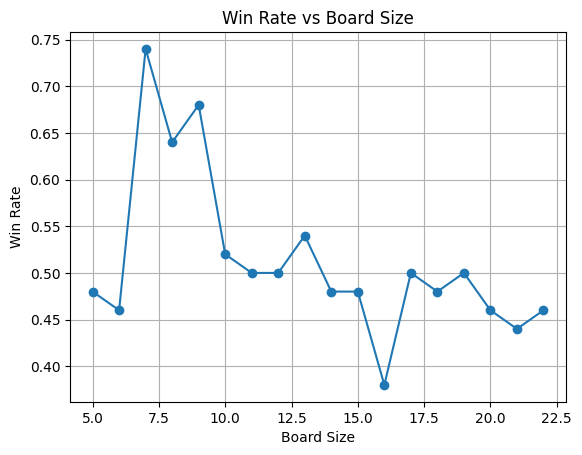

In [13]:




plt.plot(boardsizes, winrates, marker='o')

plt.xlabel('Board Size')
plt.ylabel('Win Rate')
plt.title('Win Rate vs Board Size')

plt.grid(True)

plt.show()


This model has a transformer that operates on a 3 by 3 window with a positional encoding from the entire board so the board is encoded as a 3 by 3 by 3 tensor. It acts like a CNN but with an awareness of where it is across the entire board via attention. Additionally in its stride I set the board of probabilities to the highest probability found for each square which I suspect for mines is when it is in the middle. To improve training I added a dropout feature, overfitting was not too much of an issue since I was only training on 3 by 3 boards and the model is quite large. This model preforms quite well on large boards except it takes a long time to run.